# Imports

In [2]:
import pickle
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
import re
import nltk
import contractions
import spacy
from scipy.sparse import hstack
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from xgboost import XGBClassifier

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/vasco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vasco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Reading the file and converting it to a DataFrame
def read_file_to_dataframe(filename):
    data = []
    
    with open("./data/" + filename, 'r', encoding='utf-8') as file:
        for linha in file:
            linha = linha.strip()  # Remove leading/trailing spaces and newlines
            filme = linha.split('\t')  # Split by tab
            data.append(filme)  # Append the row to the data list
    
    # Convert the list of rows to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df


In [4]:
# Reading csv file and converting it to a DataFrame
def read_csv_to_dataframe(filename):
    df = pd.read_csv("./data/" + filename)
    return df

In [5]:
# Filtering dataframe for genres in our list and rows with all collumnds filled
def filter_dataframe(df, genres):
    df = df[df['Genre'].isin(genres)]
    df = df.dropna()
    return df

In [6]:
# Add headers to train.txt dataframe

def addHeadersToTrain(df):
    df.columns = ['Title','Origin/Ethnicity' ,'Genre', 'Director', 'Plot']
    return df

# Variaveis onde está os ficheiros de treino e o modelo

In [7]:
#file onde já está o modelo treinado"
model=None

#limpesa de ficheiro de treino
# data="filmesDataset"
data= "train"
#ficheiro onde vai ser feita ao autoavaliacao
avaliation = "test_no_labels"

In [8]:
print("\033[34mData to DataFrame\n\033[0m")
# Example usage
allowed_genres = ["drama", "comedy", "horror", "action", "romance", "western", "animation", "crime", "sci-fi"]

# df = read_csv_to_dataframe(data+".csv")
# df = df.drop(columns=['Unnamed: 8'])
df = read_file_to_dataframe(data+".txt")
df = addHeadersToTrain(df)
df = filter_dataframe(df, allowed_genres)
print(df)


Data to DataFrame

                          Title Origin/Ethnicity    Genre  \
0                  Ela Cheppanu           Telugu  romance   
1     A Nightmare on Elm Street         American   horror   
2               American Gothic         American   horror   
3                          Gang        Bollywood    crime   
4            Intimate Relations          British    drama   
...                         ...              ...      ...   
8036              Sa 'Yo Lamang         Filipino    drama   
8037          The Lemon Sisters         American    drama   
8038      Dil Ne Phir Yaad Kiya        Bollywood  romance   
8039  Rehnaa Hai Terre Dil Mein        Bollywood  romance   
8040             Things to Come          British   sci-fi   

                     Director  \
0                      Ramana   
1                Samuel Bayer   
2                  John Hough   
3                 Mazhar Khan   
4               Charles Frank   
...                       ...   
8036          Lau

8041
Average word count: 370.33


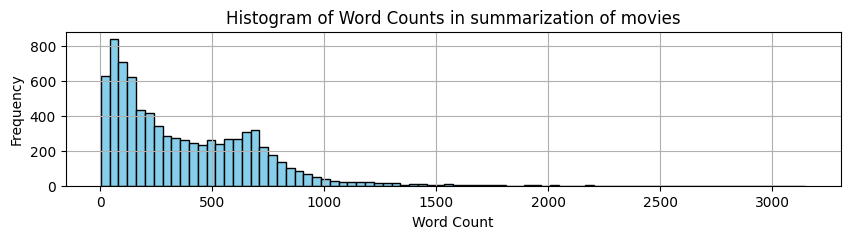

In [9]:
# histogram of word count
print(len(df))


df['word_count'] = df['Plot'].apply(lambda x: len(x.split())) 
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


the: 161014
to: 111607
and: 106034
a: 80092
of: 53504
is: 49072
his: 43843
in: 43811
he: 30869
that: 30744


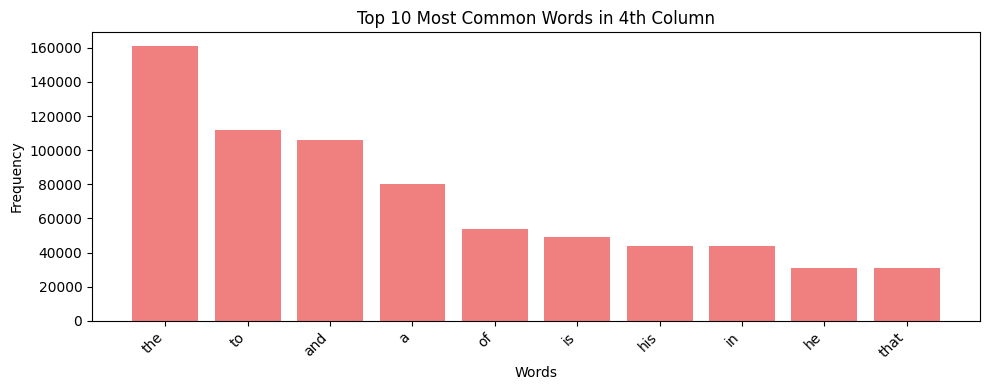

In [10]:
# Flatten all words from the 4th column into a single list
all_words = [word for row in df['Plot'] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

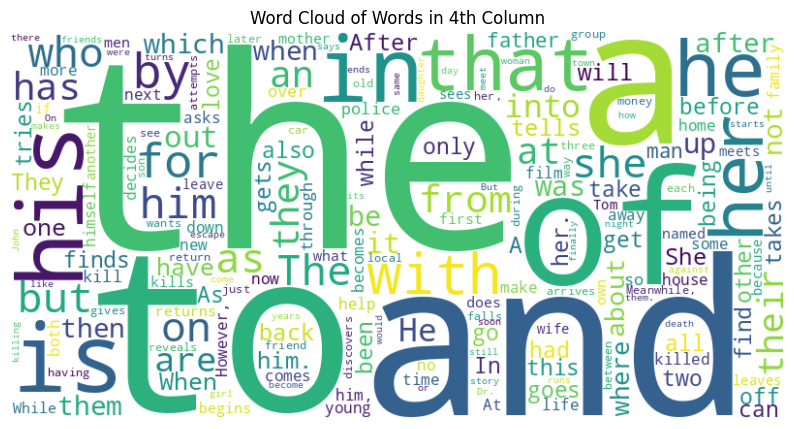

In [11]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

In [12]:
# Check for typos using the pyspellchecker
spell = SpellChecker()
misspelled_words = spell.unknown(all_words)  # Identify misspelled words

# Display the number of potential typos
print(f"Number of potential typos: {len(misspelled_words)}")

# Optionally, print the misspelled words
print("\nPotential typos detected:")
for word in misspelled_words:
    print(word)

Number of potential typos: 110157

Potential typos detected:
baja's
cissie's
supervises,
diana)
farentino
hani),
chettiar's
in-laws.
broomhilda's
(neena
sai-yuk
(datin
challenger,
bat,
laughter,
(sheldon
sasuke,
freshly-earned
bogues,
vampires.
(maría
pursuit.
‘vegas
almondine
steamers.
nangla
kirina's
(naveen
hands;
700-year-old
ochiai
college;
jonny,
instant-coffee
zeebad.
keith).
oddly,
(lancaster)
torments,
well-lit
(thornton
craig)
salman),
ecaped
bechner
rowdy.
self-destruction
lagoo)
eastwood)
roberto.
madan.
burrow.
sayaka
meetings,
fissure.
eeyore's
liz
barrows's
mohr
chūbu,
canadians
dolan's
untied,
tobio,
lazarro's
(ll
half-time
rhodes'
grief-stricken
suddenly,
rutger's
valorum
bullet:
criss-cross
three-man
annexia
cochran's
punyalanmar
gag).
president.
maiyya
qiao.
wastelands,
ahlo,
win,
carrington's
thakur
c-20
corky,
kiriko
council)
pyne),
vandiere,
(françois
(samuel)
lists,
gemini's
jennings
yocum
'saved',
morton's
subsequently,
visited,
alma.
logical,
sasaki
tulasi
bart

## Pre Processamento

In [13]:
# Function to standardize dates
def standardize_dates(text):
    def _month_to_number(month_name):
        try:
            return datetime.strptime(month_name, "%b").month  # Abbreviated month names (e.g., "Feb")
        except ValueError:
            try:
                return datetime.strptime(month_name, "%B").month  # Full month names (e.g., "February")
            except ValueError:
                return None  # Return None for invalid month names

    def _handle_two_digit_year(year):
        if not year:  # If year is None or empty
            return ""
        year = int(year)
        return year + 2000 if year < 100 else year

    # Date normalization using regex
    text = re.sub(
        r'(\b[A-Za-z]+) (\d{1,2})(?:st|nd|rd|th)?(?:,)? (\d{4})?',
        lambda match: (
            f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}/{match.group(3)}"
            if _month_to_number(match.group(1)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}"
            if _month_to_number(match.group(1)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    # Handle formats like "8-Feb-2013"
    text = re.sub(
        r'(\d{1,2})(?:st|nd|rd|th)?[-/.](\b[A-Za-z]+)\b[-/.]?(\d{2,4})?',
        lambda match: (
            f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}/{_handle_two_digit_year(match.group(3))}"
            if _month_to_number(match.group(2)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}"
            if _month_to_number(match.group(2)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    return text

In [14]:
# lowercasing
def lowercase_text(text):
    return text.lower()

In [15]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract and return lemmatized words
    lemmatized_words = [token.lemma_ for token in doc]
    return " ".join(lemmatized_words)

In [16]:
# stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text, stop_words=stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower()]
    return " ".join(filtered_words)

In [17]:
#contractions
def expand_contractions(text):
    if not isinstance(text, str) or not text:
        # Return an empty string or the original text if it's not a valid string
        return text

    try:
        # Use contractions.fix to expand contractions in the text
        return contractions.fix(text)
    except IndexError as e:
        print(f"IndexError encountered: {e}")
        # Optionally return the original text if there's an error
        return text


In [18]:
# Remove punctuation except for specific cases like "Dr." or "Mr."
def remove_punctuation(text):
    # Replace specific abbreviations with placeholders
    text = re.sub(r'\b(Dr|Mr|Ms|Mrs)\.', r'\1_PLACEHOLDER_', text)
    
    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Restore the abbreviations
    text = text.replace('_PLACEHOLDER_', '.')
    
    return text

In [19]:
def remove_references(text):
    # Substituir ".[\d]" por "."
    text = re.sub(r'\.\[\d+\]', '.', text)
    
    return text

In [20]:
print("\033[34mPre Processing the data\n\033[0m")
line_counter = 0

def preprocess_text(text):
    global line_counter
    print(f"Processing line {line_counter + 1}...")   # Print the line being processed
    line_counter += 1 
    text = expand_contractions(text)       # Step 1: Expand contractions
    text = standardize_dates(text)         # Step 2: Normalize dates
    text = lowercase_text(text)            # Step 3: Convert to lowercase
    text = remove_punctuation(text)        # Step 4: Remove punctuation but keep specific cases
    text = remove_stopwords(text)          # Step 5: Remove stopwords
    text = lemmatize_text(text)            # Step 6: Lemmatize the text
    text = remove_references(text)         # Step 7: Remove references
    
    return text

# Example usage

Pre Processing the data



In [21]:
df['Plot'] = df['Plot'].apply(preprocess_text)

print("\033[32mPre Processing Completed!\n\033[0m")

Processing line 1...
Processing line 2...
Processing line 3...
Processing line 4...
Processing line 5...
Processing line 6...
Processing line 7...
Processing line 8...
Processing line 9...
Processing line 10...
Processing line 11...
Processing line 12...
Processing line 13...
Processing line 14...
Processing line 15...
Processing line 16...
Processing line 17...
Processing line 18...
Processing line 19...
Processing line 20...
Processing line 21...
Processing line 22...
Processing line 23...
Processing line 24...
Processing line 25...
Processing line 26...
Processing line 27...
Processing line 28...
Processing line 29...
Processing line 30...
Processing line 31...
Processing line 32...
Processing line 33...
Processing line 34...
Processing line 35...
Processing line 36...
Processing line 37...
Processing line 38...
Processing line 39...
Processing line 40...
Processing line 41...
Processing line 42...
Processing line 43...
Processing line 44...
Processing line 45...
Processing line 46.

find: 9095
kill: 8870
take: 8490
go: 7931
get: 7738
leave: 7424
one: 6738
tell: 6638
man: 6592
back: 5702


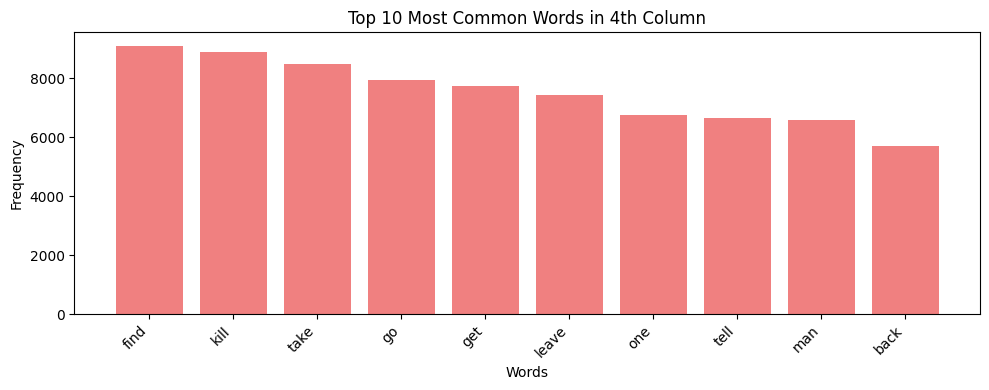

In [22]:
# Flatten all words from the 4th column into a single list after pre-processing
all_words = [word for row in df['Plot'] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

# Data after Pre Processing

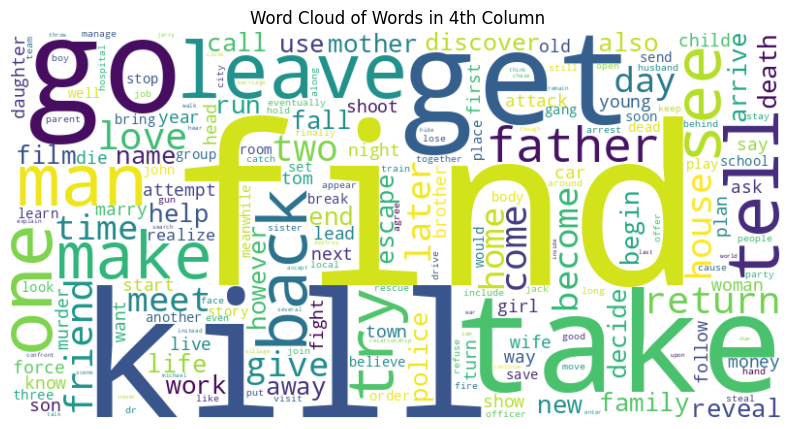

In [23]:
# Generate a word cloud after pre-processing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

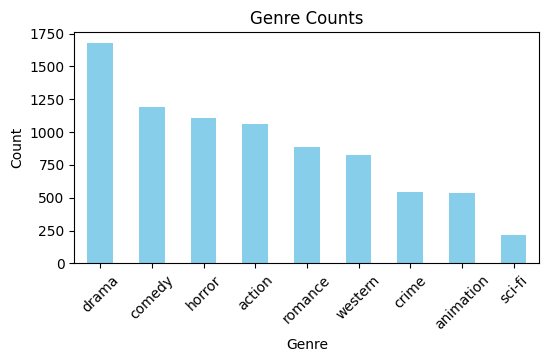

Genre
drama        1676
comedy       1193
horror       1108
action       1059
romance       886
western       829
crime         541
animation     535
sci-fi        214
Name: count, dtype: int64


In [24]:
# Genre Count for train dataset

genre_counts = df['Genre'].value_counts()

# Plot the histogram
plt.figure(figsize=(6, 3))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print(genre_counts)

## Carregar o modelo ou Criar um novo
#### Conforme o nome dado a variavel 'pklToUse'

==== MultinomialNB ====
Resultados com tfidf
              precision    recall  f1-score   support

      action       0.65      0.38      0.48       202
   animation       1.00      0.33      0.50       115
      comedy       0.57      0.25      0.35       223
       crime       0.67      0.02      0.04       108
       drama       0.32      0.90      0.48       319
      horror       0.71      0.74      0.73       223
     romance       0.66      0.24      0.35       186
      sci-fi       1.00      0.00      0.00        39
     western       0.92      0.79      0.85       194

    accuracy                           0.51      1609
   macro avg       0.72      0.41      0.42      1609
weighted avg       0.65      0.51      0.49      1609

==== GaussianNB ====
Resultados com tfidf
              precision    recall  f1-score   support

      action       0.35      0.41      0.38       202
   animation       0.69      0.43      0.53       115
      comedy       0.32      0.34      0.33  

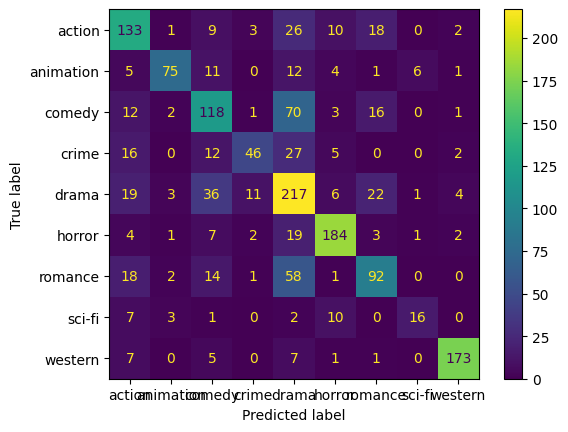

In [25]:
pklToUse = "train.txt_plot"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))
    train_indices, test_indices, y_train, y_test = train_test_split(indices, df['Genre'], test_size=0.2, random_state=42)  # random_state=42 ensures reproducibility

    # Initialize vectorizer (fitting only on the training data)

    # Fit on training data
    X_train = tfidf_vectorizer.fit_transform(df['Plot'].iloc[train_indices]).toarray()

    # Transform the test data (no fitting, just transform)
    X_test = tfidf_vectorizer.transform(df['Plot'].iloc[test_indices]).toarray()

    # One-hot encode the categorical features 
    encoder = OneHotEncoder(handle_unknown='ignore') 
    X_train_categorical = encoder.fit_transform(df.iloc[train_indices][['Director']])
    X_test_categorical = encoder.transform(df.iloc[test_indices][['Director']])

    # Com o train.txt nao há release year
    # Quando se descomentar adicionar ao x_train e x_test no fim do stack
    # scaler = MinMaxScaler()
    # X_train_numerical = scaler.fit_transform(df[['Release Year']].iloc[train_indices].astype(int))
    # X_test_numerical = scaler.transform(df[['Release Year']].iloc[test_indices].astype(int))


    x_train = hstack([X_train, X_train_categorical])
    x_test = hstack([X_test, X_test_categorical])

    y = df['Genre']      # Check if the appropriate collumn name is 'category'
    labels = np.unique(y).tolist()

    print("==== MultinomialNB ====")
    clf = MultinomialNB()

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    x_pred=clf.predict(X_test)
    print(classification_report(y_pred=x_pred, y_true=y_test, labels = labels, zero_division=1.))

    print("==== GaussianNB ====")
    clf = GaussianNB()

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    x_pred=clf.predict(X_test)
    print(classification_report(y_pred=x_pred, y_true=y_test, labels = labels, zero_division=1.))

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear') # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(X_train, y_train)
    x_pred=clf.predict(X_test)
    print(classification_report(y_pred=x_pred, y_true=y_test, labels = labels, zero_division=1.))

    confusion_matrix(y_test, x_pred)

    cm = confusion_matrix(y_test, x_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

    # Save the SVM model
    i = 1
    if i == 1:
        with open('data/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

In [26]:
print("\033[34mPre Processing the Our data\n\033[0m")

df_our = read_file_to_dataframe("our_data.txt")

print(df_our.head())

Pre Processing the Our data

                          0      1  \
0  The Adventures of Dollie  drama   
1           The Black Viper  drama   
2         A Christmas Carol  drama   
3              At the Altar  drama   
4  A Drunkard's Reformation  drama   

                                                   2  
0  On a beautiful summer day a father and mother ...  
1  A thug accosts a girl as she leaves her workpl...  
2  No prints of the first American film adaptatio...  
3  A rejected admirer sets up a trap to kill his ...  
4  John Wharton, the husband of a true and trusti...  


In [27]:
df_our.iloc[:, 2] = df_our.iloc[:, 2].apply(preprocess_text)
print("\033[32mPre Processing of Our Data Completed!\n\033[0m")

Processing line 8042...
Processing line 8043...
Processing line 8044...
Processing line 8045...
Processing line 8046...
Processing line 8047...
Processing line 8048...
Processing line 8049...
Processing line 8050...
Processing line 8051...
Processing line 8052...
Processing line 8053...
Processing line 8054...
Processing line 8055...
Processing line 8056...
Processing line 8057...
Processing line 8058...
Processing line 8059...
Processing line 8060...
Processing line 8061...
Processing line 8062...
Processing line 8063...
Processing line 8064...
Processing line 8065...
Processing line 8066...
Processing line 8067...
Processing line 8068...
Processing line 8069...
Processing line 8070...
Processing line 8071...
Processing line 8072...
Processing line 8073...
Processing line 8074...
Processing line 8075...
Processing line 8076...
Processing line 8077...
Processing line 8078...
Processing line 8079...
Processing line 8080...
Processing line 8081...
Processing line 8082...
Processing line 

              precision    recall  f1-score   support

      action       0.09      0.75      0.17        77
   animation       0.11      0.58      0.19        19
      comedy       0.69      0.50      0.58      3226
       crime       0.04      0.50      0.07        30
       drama       0.73      0.56      0.63      4310
      horror       0.22      0.86      0.35        83
     romance       0.06      0.55      0.10        60
      sci-fi       0.15      0.36      0.21        11
     western       0.18      0.84      0.30        37

    accuracy                           0.54      7853
   macro avg       0.25      0.61      0.29      7853
weighted avg       0.69      0.54      0.60      7853



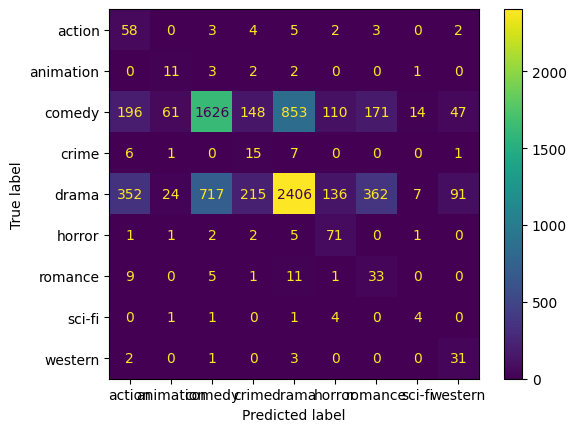

In [28]:
X_new = tfidf_vectorizer.transform(df_our.iloc[:, 2]).toarray()  # Transform it into the TF-IDF format

# Step 3: Predict the genre using the trained MLP model
y_new_pred = clf.predict(X_new)

# Step 4: Decode the predicted label to the original genre
print(classification_report(y_pred=y_new_pred, y_true=df_our.iloc[:, 1], labels = labels, zero_division=1.))

confusion_matrix(df_our.iloc[:, 1], y_new_pred)

cm = confusion_matrix(df_our.iloc[:, 1], y_new_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [29]:
print("\033[34mPre Processing the Our data\n\033[0m")

top_secret = read_file_to_dataframe("top_secret_69.txt")

print(top_secret.head())

Pre Processing the Our data

                      0               1            2  \
0                Quick    South_Korean       action    
1  Little School Mouse        American    animation    
2   The Little Damozel         British      romance    
3                  Jor         Bengali      romance    
4              Brigada         Russian        crime    

                                                   3  
0   Seoul, 2004. A group of bikers are joy-riding...  
1   Jerry decides to school Tuffy in the basics o...  
2   Gambler Recky Poole (James Rennie) accepts a ...  
3   Surya (Jeet) is a sportsman. He loves to run ...  
4   The film proceeds in chronological order, apa...  


In [30]:
top_secret.iloc[:, 2] = top_secret.iloc[:, 2].apply(preprocess_text)
print("\033[32mPre Processing of Our Data Completed!\n\033[0m")

Processing line 15895...
Processing line 15896...
Processing line 15897...
Processing line 15898...
Processing line 15899...
Processing line 15900...
Processing line 15901...
Processing line 15902...
Processing line 15903...
Processing line 15904...
Processing line 15905...
Processing line 15906...
Processing line 15907...
Processing line 15908...
Processing line 15909...
Processing line 15910...
Processing line 15911...
Processing line 15912...
Processing line 15913...
Processing line 15914...
Processing line 15915...
Processing line 15916...
Processing line 15917...
Processing line 15918...
Processing line 15919...
Processing line 15920...
Processing line 15921...
Processing line 15922...
Processing line 15923...
Processing line 15924...
Processing line 15925...
Processing line 15926...
Processing line 15927...
Processing line 15928...
Processing line 15929...
Processing line 15930...
Processing line 15931...
Processing line 15932...
Processing line 15933...
Processing line 15934...


              precision    recall  f1-score   support

      action       0.60      0.66      0.63        58
   animation       0.57      0.31      0.40        13
      comedy       0.41      0.48      0.44        54
       crime       0.50      0.35      0.41        26
       drama       0.39      0.65      0.49        65
      horror       0.80      0.63      0.70        59
     romance       0.64      0.40      0.49        52
      sci-fi       0.00      1.00      0.00         0
     western       0.93      0.80      0.86        35

   micro avg       0.55      0.57      0.56       362
   macro avg       0.54      0.59      0.49       362
weighted avg       0.60      0.57      0.57       362



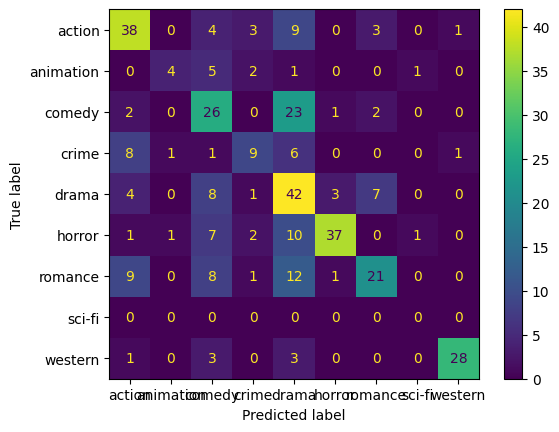

In [31]:
X_new = tfidf_vectorizer.transform(top_secret.iloc[:, 3]).toarray()  # Transform it into the TF-IDF format

# Step 3: Predict the genre using the trained MLP model
y_new_pred = clf.predict(X_new)

# Step 4: Decode the predicted label to the original genre
print(classification_report(y_pred=y_new_pred, y_true=top_secret.iloc[:, 2], labels = labels, zero_division=1.))

confusion_matrix(top_secret.iloc[:, 2], y_new_pred)

cm = confusion_matrix(top_secret.iloc[:, 2], y_new_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Resultados

- 54% com 

